In [1]:
import os
import sys
import json
from argparse import Namespace

import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from model.DepthGenLM import DepthGenLM
from datasets.ITSEDataset import ITSEDataset

In [2]:
def plot_hands(ax, points, color, linewidth='3'):
    # Add bone connections
    bones = [(0, 1),
             (1, 2),
             (2, 3),
             (3, 4),
             (0, 21),
             (21, 5),
             (5, 6),
             (6, 7),
             (7, 8),
             (21, 9),
             (9, 10),
             (10, 11),
             (11, 12),
             (21, 13),
             (13, 14),
             (14, 15),
             (15, 16),
             (21, 17),
             (17, 18),
             (18, 19),
             (19, 20)]

    for connection in bones:
        coord1 = points[connection[0]]
        coord2 = points[connection[1]]
        coords = np.stack([coord1, coord2])
        ax.plot(coords[:, 0], coords[:, 1], coords[:, 2], c=color, linewidth=linewidth)

In [3]:
tsfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224, Image.NEAREST),
    transforms.ToTensor()
])
dataset = ITSEDataset("/home/alex/Data/itsef/train", sample_transform=tsfms)

In [4]:
hparams = Namespace(**json.load(open("../configs/resnet_itse.json")))
model = DepthGenLM(hparams)
weights_path = "../saved/resnet_multiview_synth_pretrain.ckpt"
weights = torch.load(weights_path)
model.load_state_dict(weights['state_dict'])
model.cuda()
model.eval()

DepthGenLM(
  (estimator): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

torch.Size([1, 26, 3])


<IPython.core.display.Javascript object>


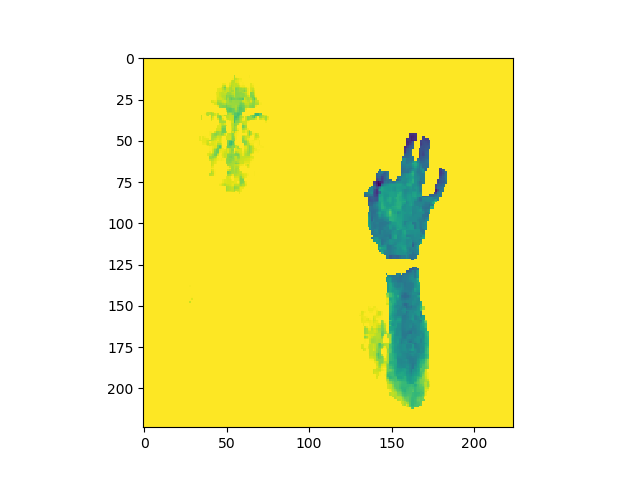

<IPython.core.display.Javascript object>


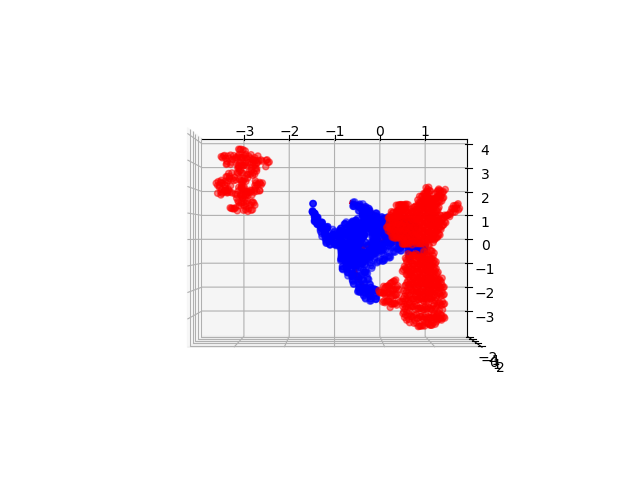

In [6]:
sample, target = dataset[0]

preds, _ = model(sample.unsqueeze(0).cuda())
coord = preds[2]
print(coord.shape)
joint_idxs = [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 22, 23, 24, 25, 6]
coord_vis = coord[0, joint_idxs].detach().cpu()
points_vis = preds[0][0].detach().cpu()
y_vis = target.cpu()

%matplotlib notebook
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.imshow(sample[0])

fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')
plot_hands(ax2, coord_vis, color='r')
ax2.scatter(points_vis[:, 0], points_vis[:, 1], points_vis[:, 2], c='b', alpha=0.5)
ax2.scatter(y_vis[:, 0], y_vis[:, 1], y_vis[:, 2], c='r', alpha=0.5)
ax2.view_init(90, -90)